In [6]:
import h5py
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from unet import Unet3D
from diffuser import GaussianDiffusion
import tqdm

In [2]:
from data import NaiverStokes_Dataset

In [3]:
ds = NaiverStokes_Dataset('../../data/ns_V1e-5_T20_test.h5')

Loaded 200 samples from ../../data/ns_V1e-5_T20_test.h5


In [4]:
denoising_fn = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    denoising_fn=denoising_fn,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    sampling_timesteps=1000
).cuda(0)

In [5]:
diffuser.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [13]:
n = np.random.randint(0, len(ds))
x = ds[n]['x']
x_pred = diffuser.sample(cond=ds[n]['y'].unsqueeze(0))

DDPM sampling: 100%|██████████| 1000/1000 [00:47<00:00, 21.00it/s]


In [14]:
x_pred = x_pred.detach().cpu()

In [15]:
x_pred = x_pred.squeeze()
x = x.squeeze()

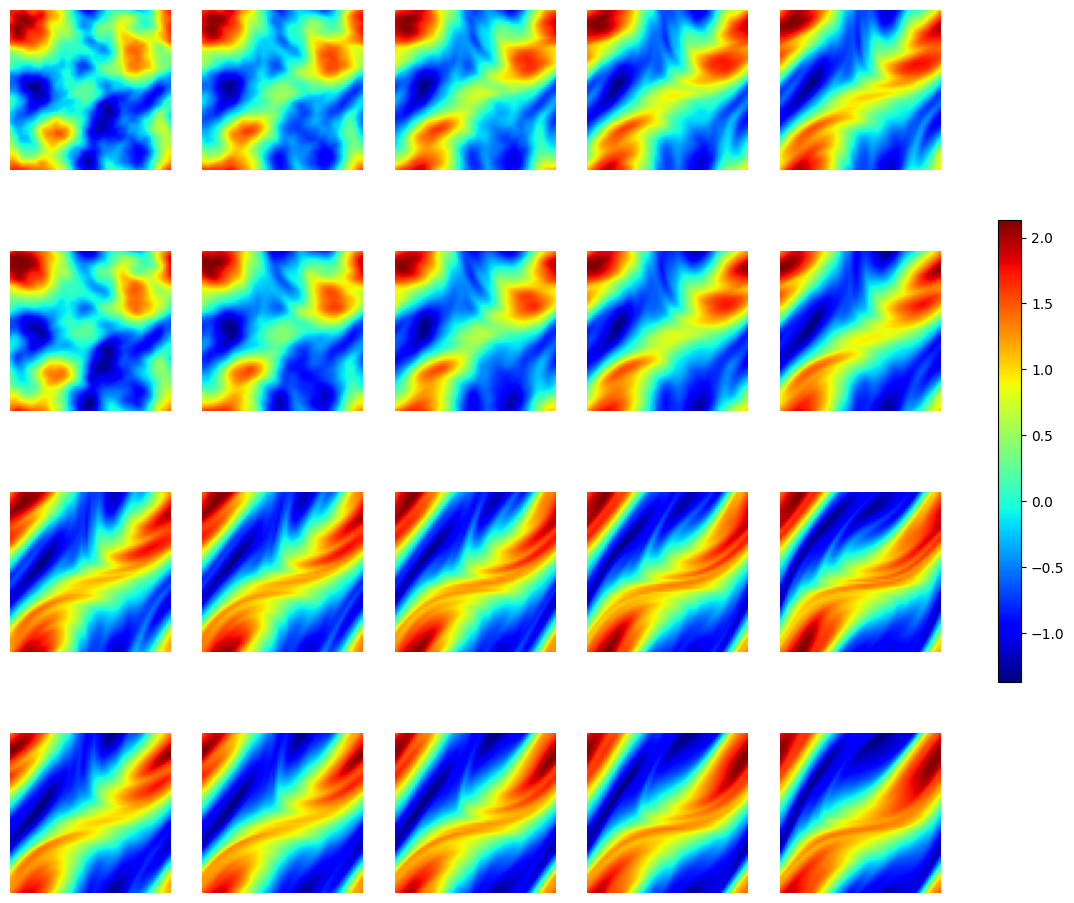

In [17]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
for i in range(5):
    im = ax[0, i].imshow(x[i], cmap='jet')
    ax[0, i].axis('off')
    im = ax[1, i].imshow(x_pred[i], cmap='jet')
    ax[1, i].axis('off')
    im = ax[2, i].imshow(x[i+5], cmap='jet')
    ax[2, i].axis('off')
    im = ax[3, i].imshow(x_pred[i+5], cmap='jet')
    ax[3, i].axis('off')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
    

In [21]:
denoising_fn_lamb = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser_lamb = GaussianDiffusion(
    denoising_fn=denoising_fn_lamb,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    sampling_timesteps=1000
).cuda(0)

In [22]:
diffuser_lamb.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20_0.1phyloss/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [23]:
x_pred_lamb = diffuser_lamb.sample(cond=ds[n]['y'].unsqueeze(0))

DDPM sampling: 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


In [24]:
x_pred_lamb = x_pred_lamb.detach().cpu()
x_pred_lamb = x_pred_lamb.squeeze()

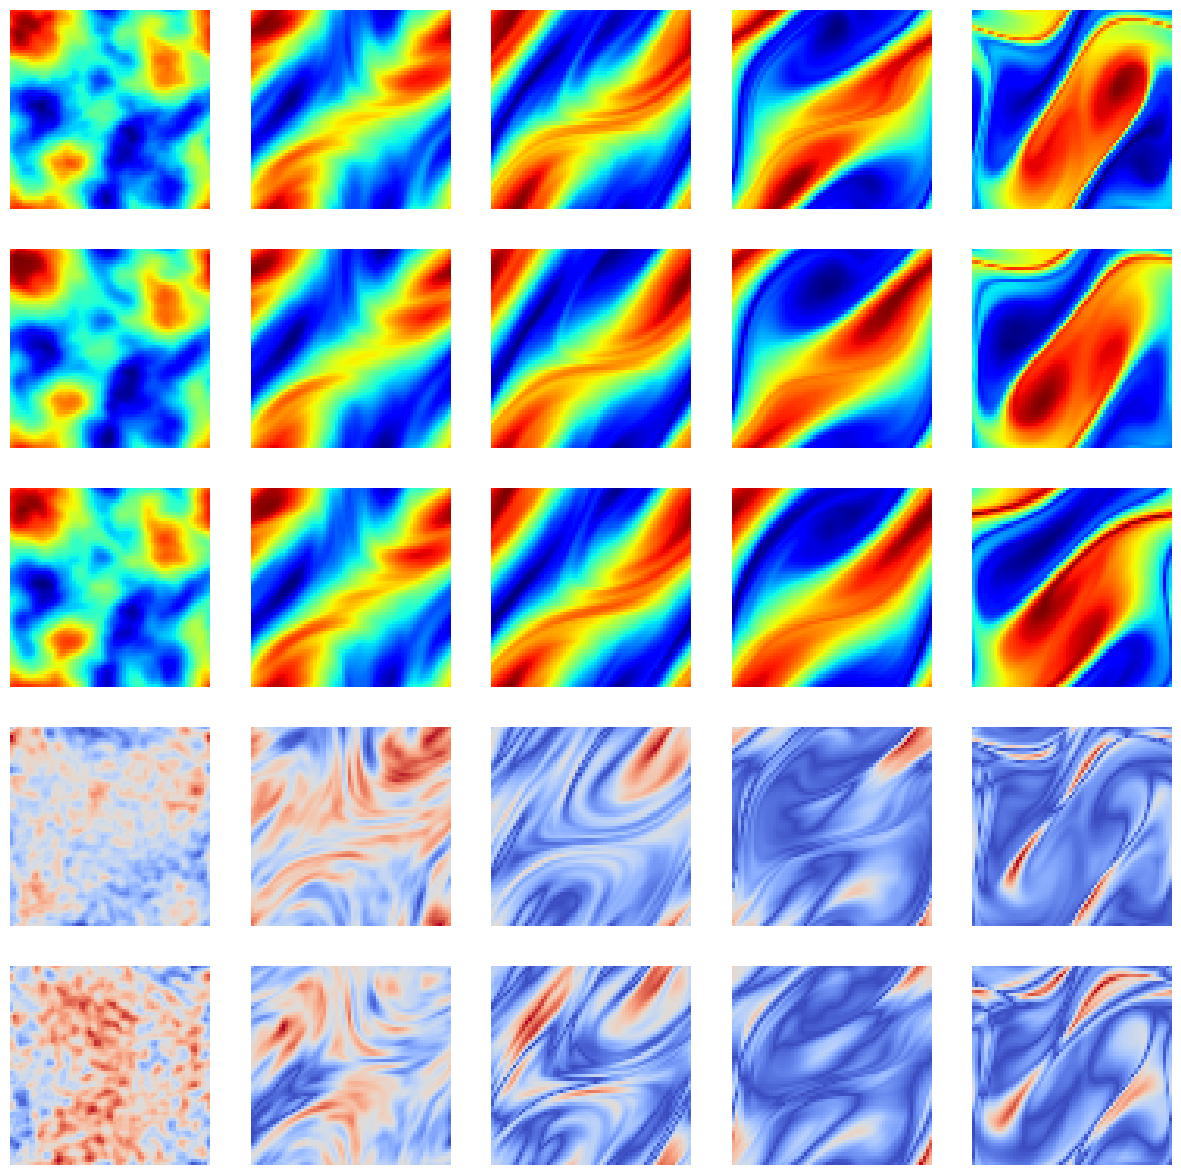

In [26]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    ax[0, i].imshow(x[i*4], cmap='jet')
    ax[0, i].axis('off')
    ax[1, i].imshow(x_pred[i*4], cmap='jet')
    ax[1, i].axis('off')
    ax[2, i].imshow(x_pred_lamb[i*4], cmap='jet')
    ax[2, i].axis('off')
    ax[3, i].imshow(torch.abs(x_pred[i*4] - x[i*4]), cmap='coolwarm')
    ax[3, i].axis('off')
    ax[4, i].imshow(torch.abs(x_pred_lamb[i*4] - x[i*4]), cmap='coolwarm')
    ax[4, i].axis('off')

In [10]:

with torch.no_grad():
    y = ds[4]['y'].unsqueeze(0).cuda(0)
    xt = torch.randn(1, *diffuser.sample_size).cuda(0)
    x0_recons = []

    for t in tqdm.tqdm(reversed(range(0, diffuser.num_timesteps))):
        batched_t = torch.full((xt.shape[0],), t, dtype=torch.long, device=xt.device)
        eps_theta = diffuser.denoising_fn(xt, batched_t, cond=y)
        x0_recon = diffuser.predict_x0_from_xt(xt=xt, t=batched_t, eps=eps_theta)
        xt = diffuser.p_sample(xt=xt, t=t, cond=y)
        if t % 10 == 0:
            x0_recons.append(x0_recon)

1000it [01:36, 10.38it/s]


In [12]:
x0_recons[0].shape

torch.Size([1, 1, 20, 64, 64])

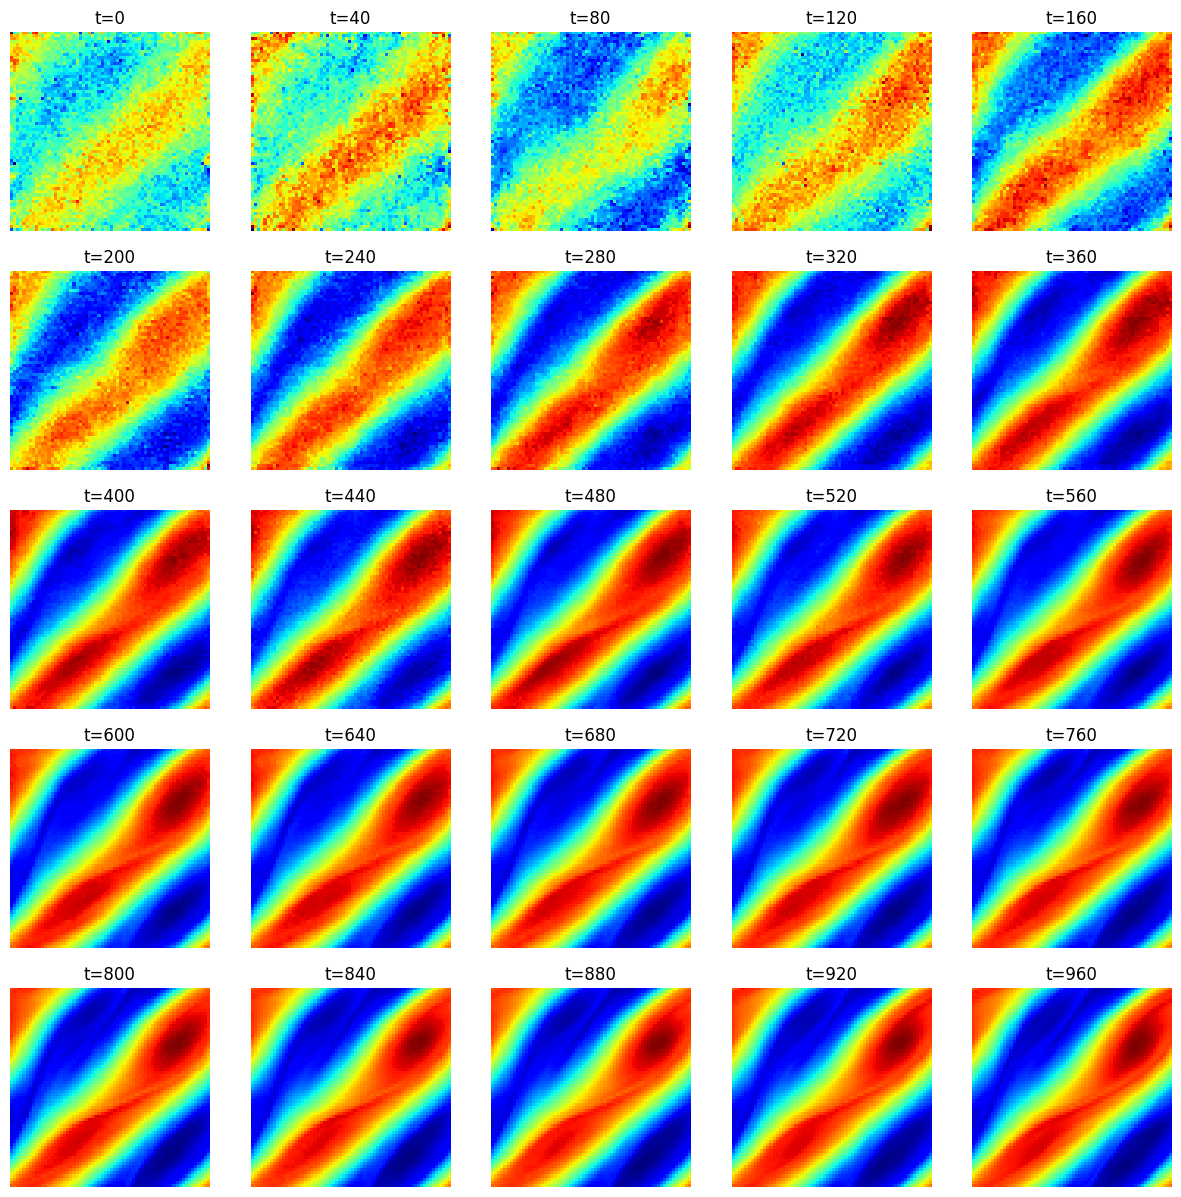

In [19]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(x0_recons[(i*5+j)*4][0, 0, 10].cpu(), cmap='jet')
        ax[i, j].axis('off')
        ax[i, j].set_title(f't={(i*5+j)*40}')